## Training Notebook:

Currently Handles only case of single task - can be adapted for mutlitask output by summing across losses and taking a step back in that way: See --> https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086

**Requirements:**

1) Pytorch and all subclasses (eg., nn and F) <br>
2) DontGetSNPpyWithMe.py in same folder as this notebook<br>
3) EarlyStop.py in same folder as this notebook 

**Import necessary packages:**

In [1]:
import torch 
import argparse
import os
import numpy as np
from torch.utils.data import DataLoader
from DontGetSNPpyWithMe import * #The neural net
import torch.optim as optim
import torch.nn.functional as F
from EarlyStop import * #Early Stopping object
from data_loader import *
from SecretTunnels import *
import matplotlib.pyplot as plt

**Define a Validation Splitting Function (maybe handle externally by randomly sampling in a phenotype balanced way so can just read in and go here), and read in training, validation, and test (openSNP) data:**

Define variables that can be easily changed for model instantiation later in one place:

In [2]:
batchSize = 32
numSNPs= 276569  # 500000
numLayers = 5
layerWidths = [512, 512, 256, 128, 64]
dropout = 0.5
multitaskOutputs = [3]
learningRate = 5e-3
epochs = 5
patience = 5
weighted = True

do dataloader tings: --> **Edited** so Train is shuffled so no random unbalanced batches throw everything off by accident

Guess test and val train don't matter if shuffled since just eval-ing it

In [3]:
train_loader = get_loader(genotype_file="../Sheen/train_set.pickle",
                          phenotype_file="../Sheen/train_labels.csv",
                          batch_size=batchSize,
                          shuffle=True,
                          num_workers=4,
                          pickle=True)
val_loader = get_loader(genotype_file="../Sheen/val_set.pickle",
                          phenotype_file="../Sheen/val_labels.csv",
                          batch_size=batchSize,
                          shuffle=False,
                          num_workers=4,
                          pickle=True)
test_loader = get_loader(genotype_file="../Sheen/test_set.pickle",
                          phenotype_file="../Sheen/test_labels.csv",
                          batch_size=batchSize,
                          shuffle=False,
                          num_workers=4,
                          pickle=True)

In [4]:
#len(test_loader.dataset[0][0])

In [5]:
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset[0][0]), len(train_loader.dataset)))
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset[0][0]), len(val_loader.dataset)))
print("Dimensions of test set: {} x {}".format(len(test_loader.dataset[0][0]), len(test_loader.dataset)))

Dimensions of training set: 276569 x 2002
Dimensions of validation set: 276569 x 500
Dimensions of test set: 276569 x 589


Instantiate the model, loss function, and optimizer using the above parameters:

In [6]:
soHeavy = [1/1784, 1/214 , 1/5]  # 1/class_size for now

In [7]:
derekZoolander = DiddyKongRacing([batchSize,numSNPs], numLayers, layerWidths, dropout, multitaskOutputs)
optimizer = optim.Adam(derekZoolander.parameters(), lr=learningRate) # can add in regularization w/ wd as well later: weight_decay=1e-4) 

Move the model to gpu if available:

In [8]:
pleaseBeGpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(pleaseBeGpu)
derekZoolander = derekZoolander.to(pleaseBeGpu)
torchMe = torch.FloatTensor(soHeavy).to(pleaseBeGpu)
if weighted:
    criterion = nn.CrossEntropyLoss(weight=torchMe)  # Implement weighted loss
    print("Using Weighted Cross Entropy as Loss f(x)")
else: 
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted Cross Entropy as Loss f(x)")

cuda
Using Weighted Cross Entropy as Loss f(x)


Define a Function to calc accuracy on a batch since the model returns raw outputs and not softmax!:

In [9]:
#input of 2 tensors --> make sure labels is a tensor of size == batch size
#output: Total number of matches (accuracy can be returned by removing the comment # below); 
# this was done to get accuracy on an epoch basis where can be weighted by total number of samples as opposed to a per batch basis
def AccuracyCalc(raw, labels): 
    payMeForMyPredictions = torch.argmax(F.softmax(raw, dim = 1), dim = 1)
    return sum(payMeForMyPredictions.eq(labels)).item() #/len(lables)

Define a validation (and Test) function (also base case of evaluation for epoch 0): 

Can mute print statements later when running everything especially with test set and when plotting is integrated but for now they are there to ensure things intuitively are working and can get a sense model is improving in real time.

In [10]:
#inputs: 1) model (derekZoolander) 2) current epoch number 3) validation dataloader 4) Loss function 5) device
#outputs: 1) accuracy 2) loss

def Validate(model, epochNum, data = val_loader, lossFn = criterion, device = pleaseBeGpu):
    model.eval() #shut off batch norm and dropout
    # numBatches = 0 in case want to know how many batches iterating through
    totalSamples = 0
    totalLoss = 0
    numerator = 0
    for i, (snpBatch, phenotypeBatch) in enumerate(data):            
        totalSamples += len(phenotypeBatch) #running total of number of samples

        #move labels to gpu (hopefully)
        snpBatch = snpBatch.to(device)
        phenotypeBatch = phenotypeBatch.to(device)

        #Run it:
        output = model(snpBatch)
        loss = lossFn(output[0], phenotypeBatch.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]

        #Calculate accuracy:
        numerator += AccuracyCalc(output[0], phenotypeBatch.squeeze(1))
        totalLoss += loss.item()
        
    epochAcc = numerator/(totalSamples)
    totalLoss = totalLoss/totalSamples
    #print("Validation accuracy at epoch {} is: {} .".format(epochNum,epochAcc))
    return epochAcc, totalLoss

Define a training f(x):

In [11]:
#Inputs: 1) model 2) Number of epochs want to train for 3) training dataloader 4) loss function 
# 5) the device available (cpu or gpu/cuda --> hopefully it is the latter)

#Outputs: 4 lists corresponding to a per epoch basis of accuracies and losses
# 1) Training Accs 2) Training Losses 3) Validation Accuracies 4) Validation Losses

def Train(model, numEpochs = epochs, data = train_loader, lossFn = criterion, device = pleaseBeGpu, modName="LankyKong"):
    
    #Lists of training accuracies and losses to return for visualization later
    losses = []
    accuracies = []
    
    #do base case of untrained: 
    trainZeroAcc,trainZeroLoss = Validate(model, 0, data = train_loader)
    accuracies.append(trainZeroAcc)
    losses.append(trainZeroLoss)
    del trainZeroAcc, trainZeroLoss
    
    
    #Lists of validation accuracies and losses to return for visualization later
    valAccs = []
    valLosses = []
    #do baseCase of untrained:
    valZeroAcc,valZeroLoss = Validate(model, 0, data = val_loader)
    valAccs.append(valZeroAcc)
    valLosses.append(valZeroLoss)
    del valZeroAcc,valZeroLoss
    
    #Early stopping structures: 
    stop = EarlyStop(patience) #Create an EarlyStop object that will evaluate and save the best model if patience has been exceeded
    areWeThereYet = False #flag for condition of early stopping
    topDog = None #Best model to save if early stopping condition has been met
    
    #whereStopped = -1 #if early stopping where did it stop? --> new value that is returned will give the number of epochs trained + 1 so that plotting is easy
    
    for epoch in range(numEpochs):
        model.train() # turn on batch norm and dropout
        numerator = 0
        # numBatches = 0 in case want to know how many batches iterating through
        totalSamples = 0
        totalLoss = 0
        for i, (snpBatch, phenotypeBatch) in enumerate(data):
            #numBatches += 1 
            #print(snpBatch)
            #print(phenotypeBatch)
            totalSamples += len(phenotypeBatch) #running total of number of samples
            
            optimizer.zero_grad() #zero the gradient to prevent accumulation; apparently can also do model.zero_grad() as well and does the same thing...
            
            #move labels to gpu (hopefully)
            snpBatch = snpBatch.to(device)
            phenotypeBatch = phenotypeBatch.to(device)
            
            #Run it:
            output = model(snpBatch)
            loss = lossFn(output[0], phenotypeBatch.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]
            
            #Calculate accuracy:
            numerator += AccuracyCalc(output[0], phenotypeBatch.squeeze(1))
            totalLoss += loss.item()
            
            #Train it: 
            loss.backward()
            optimizer.step()

            
        epochAcc = numerator/(totalSamples)
        totalLoss = totalLoss/totalSamples
        #print("Training accuracy at epoch {} is: {} .".format(epoch+1,epochAcc))
        #print("Training loss at epoch {} is : {} .".format(epoch+1, totalLoss))
        accuracies.append(epochAcc)
        losses.append(totalLoss)
        
        #Make some sort of call to Val when finished --> can discuss how want to do this of not a happy camper w/ this
        valAcc, valLoss = Validate(model, epoch + 1, data = val_loader)
        valAccs.append(valAcc)
        valLosses.append(valLoss)
        
        #Early Stopping: 
        areWeThereYet, topDog = stop(valLoss, model)
        if areWeThereYet:
            #Change this name later so can include hyperparametrs, etc
            torch.save(topDog.state_dict(), '../models/{}.pt'.format("BestModel_"+ modName + "_" +str(epoch) +"_epochs_" + str(numLayers) + "_hiddenLayers")) 
            print("Early stopping at epoch:" + str(epoch+1))
            #whereStopped = epoch + 1
            break
        
        
    #Save final model if no early stopping
    if not areWeThereYet:
        print("Ugh didn't get to go home early, well lets save the final epoch model anyway.")
        torch.save(topDog.state_dict(), '../models/{}.pt'.format("BestModel_" + modName + "_" +str(epochs) +"_epochs_" + str(numLayers) + "_hiddenLayers"))
        #whereStopped = numEpochs + 1
    return accuracies, losses, valAccs, valLosses #, whereStopped

In [12]:
# Test with dataloader
#t_accs, t_losses, val_accs, val_losses, \
#    = Train(derekZoolander, numEpochs = epochs, data = train_loader, lossFn = criterion, device = pleaseBeGpu)

Quick Test run to ensure skeleton code (should) work(s):

**Seems to run properly!**

Main F(x) (or some sort of cohesive structure) and Plotting: Tbd

In [13]:
# Loss plotting
'''
fig,ax = plt.subplots(figsize=(6,5))
ax.set_ylabel('Losses')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, endPlace), t_losses,'b-',color="blue",label="train")
_=ax.plot(range(0, endPlace), val_losses,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")
#plt.savefig()
'''

'\nfig,ax = plt.subplots(figsize=(6,5))\nax.set_ylabel(\'Losses\')\nax.set_xlabel(\'Epochs\')\n_=ax.plot(range(0, endPlace), t_losses,\'b-\',color="blue",label="train")\n_=ax.plot(range(0, endPlace), val_losses,\'b-\',color="orange",label="valid")\nplt.legend()\nplt.title("Loss on training set and holdout set vs. number of epochs")\n#plt.savefig()\n'

In [14]:
'''
# Accuracy plotting
fig,ax = plt.subplots(figsize=(6,5))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, endPlace), t_accs,'b-',color="blue",label="train")
_=ax.plot(range(0, endPlace), val_accs,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")
'''

'\n# Accuracy plotting\nfig,ax = plt.subplots(figsize=(6,5))\nax.set_ylabel(\'Accuracies\')\nax.set_xlabel(\'Epochs\')\n_=ax.plot(range(0, endPlace), t_accs,\'b-\',color="blue",label="train")\n_=ax.plot(range(0, endPlace), val_accs,\'b-\',color="orange",label="valid")\nplt.legend()\nplt.title("Loss on training set and holdout set vs. number of epochs")\n'

In [15]:
# Running through the test set
#test_acc, test_loss = Validate(derekZoolander, 
#                               epochNum=0, 
#                               data = test_loader, 
#                               lossFn = criterion, 
#                               device = pleaseBeGpu)

For convenience before everything that was instantiated previously is here in case want to change later: Commented out cells are those that are hyperparameter searched for or instantiated differently in automagic handling of this...

In [16]:
batchSize = 32
numSNPs= 276569  

#numLayers = 5
#layerWidths = [512, 512, 256, 128, 64]

dropout = 0.5
multitaskOutputs = [3]
learningRate = 5e-3
epochs = 100
patience = 5
weighted = True #The flag for the loss function


#derekZoolander = DiddyKongRacing([batchSize,numSNPs], numLayers, layerWidths, dropout, multitaskOutputs)
#optimizer = optim.Adam(derekZoolander.parameters(), lr=learningRate)


pleaseBeGpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("What are we using? {}".format(pleaseBeGpu))

#derekZoolander = derekZoolander.to(pleaseBeGpu)

soHeavy = [1/1784, 1/214 , 1/5]  # 1/class_size for now
torchMe = torch.FloatTensor(soHeavy).to(pleaseBeGpu)
if weighted:
    criterion = nn.CrossEntropyLoss(weight=torchMe)  # Implement weighted loss
    print("Using Weighted Cross Entropy as Loss f(x)")
else: 
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted Cross Entropy as Loss f(x)")

What are we using? cuda
Using Weighted Cross Entropy as Loss f(x)


Beginning Model: 1


Ugh didn't get to go home early, well lets save the final epoch model anyway.

Finished model - 1 Nobody tosses a dwarf!

Beginning Model: 2


Ugh didn't get to go home early, well lets save the final epoch model anyway.

Finished model - 2 Angelica is coming... Somebody Call Reptar!

Beginning Model: 3


Ugh didn't get to go home early, well lets save the final epoch model anyway.

Finished model - 3 Model generation takes a lot out of you - I could go for some Covid Pretzels



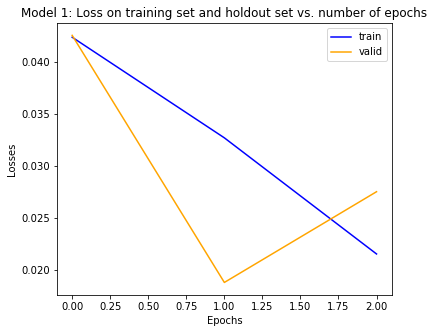

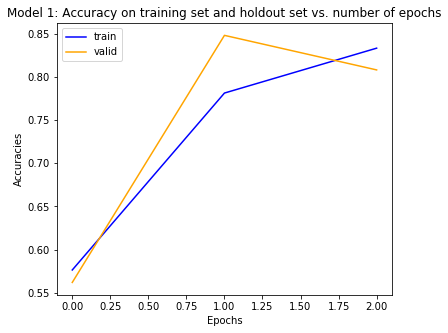

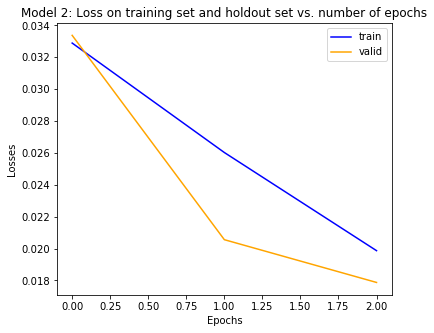

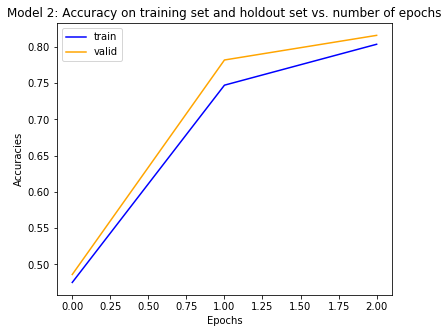

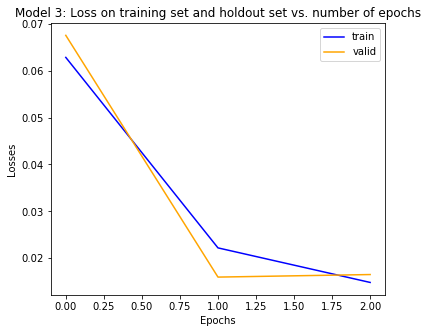

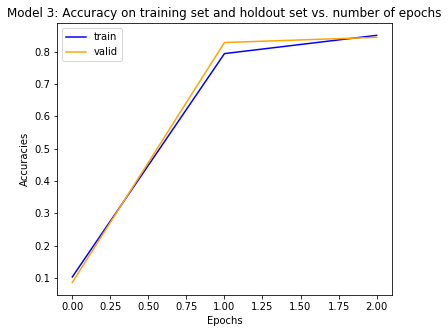

In [17]:
if __name__ == "__main__":
    hyperParameterSearchFile = pd.read_csv("TestingForAutomation.csv") #--> Don't trample me Stu Pickles I used read_csv... 
    
    for i, row in hyperParameterSearchFile.iterrows():
        print("Beginning Model: " + str(row["Model"]))
        numLayers = row["Num_hidden_layers"]
        layerWidths = list(map(int, row["Layer_widths"].split(",")))
        hansel = DiddyKongRacing([batchSize,numSNPs], numLayers, layerWidths, dropout, multitaskOutputs)
        optimizer = optim.Adam(hansel.parameters(), lr=learningRate)
        
        hansel = hansel.to(pleaseBeGpu)
        
        t_accs, t_losses, val_accs, val_losses\
    = Train(hansel, numEpochs = epochs, data = train_loader, lossFn = criterion, device = pleaseBeGpu, modName = str(row["Model"]))
        
        hyperParameterSearchFile.loc[i, "Train_Acc"] = t_accs[len(t_accs) - 1]
        hyperParameterSearchFile.loc[i, "Val_Acc"] = val_accs[len(val_accs) - 1]
        hyperParameterSearchFile.loc[i, "Val_Loss"] = val_losses[len(val_losses)-1]
        hyperParameterSearchFile.loc[i, "Train_Loss"] = t_losses[len(t_losses) - 1]
        hyperParameterSearchFile.loc[i, "Early_Stopping_Epoch"] = len(val_losses) - 1 #since handled 0 instance case the number of trained epochs is the length-1 
        
        
        crossTraining = open("../Statistics/Model" + str(row["Model"])+"_TrainStatistics.txt", 'w') #should be output in csv format
        crossTraining.write("Loss,Acc\n")
        for i in range(len(t_accs)): 
            crossTraining.write(str(t_losses[i]) + "," + str(t_accs[i])+ "\n")
        crossTraining.close()
        
        
        trustButVerify = open("../Statistics/Model" + str(row["Model"])+ "_ValStatistics.txt", 'w')
        trustButVerify.write("Loss,Acc\n")
        for i in range(len(val_accs)):
            trustButVerify.write(str(val_losses[i]) + "," + str(val_accs[i])+ "\n")
        trustButVerify.close()
        
        
        fig,ax = plt.subplots(figsize=(6,5))
        ax.set_ylabel('Losses')
        ax.set_xlabel('Epochs')
        _=ax.plot(range(0, len(t_losses)), t_losses,'b-',color="blue",label="train")
        _=ax.plot(range(0, len(val_losses)), val_losses,'b-',color="orange",label="valid")
        plt.legend()
        plt.title("Model "+ str(row["Model"]) + ": Loss on training set and holdout set vs. number of epochs")
        plt.savefig("../Plots/Model" + str(row["Model"])+ "_Losses.png")
        
        fig,ax = plt.subplots(figsize=(6,5))
        ax.set_ylabel('Accuracies')
        ax.set_xlabel('Epochs')
        _=ax.plot(range(0, len(t_accs)), t_accs,'b-',color="blue",label="train")
        _=ax.plot(range(0, len(val_accs)), val_accs,'b-',color="orange",label="valid")
        plt.legend()
        plt.title("Model "+ str(row["Model"]) + ": Accuracy on training set and holdout set vs. number of epochs")
        plt.savefig("../Plots/Model" + str(row["Model"])+ "_Accuracies.png")
        
        del hansel,optimizer #don't want to save this each time --> best model is already saved in models folder 
        print("\nFinished model " + str(row["Model"])+ " - " + SomethingClever() +"\n")
        
    hyperParameterSearchFile.to_csv("LookAtThisWizardry.csv")

In [18]:
hyperParameterSearchFile.head()

,Model,Num_hidden_layers,Layer_widths,Train_Acc,Val_Acc,Train_Loss,Val_Loss,Early_Stopping_Epoch
0,1,5,"512,512,512,512,512",0.833167,0.808,0.021516,0.027497,2.0
1,2,5,"256,256,256,256,128",0.803696,0.816,0.019868,0.017874,2.0
2,3,3,"1024,256,32",0.850150,0.844,0.014830,0.016515,2.0


In [20]:
#pd.read_csv("../Statistics/Model_1_TrainStatistics.txt")